# Age estimation using a CNN and UTKFace

The UTKFace dataset die hier gebruikt wordt is op de volgende locatie te vinden [link](https://susanqq.github.io/UTKFace/). The 3 datasets worden gedownload als UTKFace folder part1, part2, part3. 

In [1]:
# Importeer packages
import os
import re 

import matplotlib.pyplot as plt
import numpy as np

import tensorflow as tf
from tensorflow.keras import layers, models
from sklearn.model_selection import train_test_split
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.preprocessing.image import img_to_array, load_img

ModuleNotFoundError: No module named 'tensorflow'

## Loading the image data and extracting the features from the file name

Zorg ervoor dat je een map hebt waar deze code in staat, met daarin de map UTKFace waar je part 1, part 2 en part 3 instopt die je hiervoor hebt gedownload!

In [ ]:
#Path to the UTKFace dataset
utkface_dir = 'UTKFace'

image_paths = []
ages = []
genders = []
races = []

#Regex to extract labels from filename
pattern = re.compile(r'^(\d+)_(\d+)_(\d+)_')

for part in ['part1', 'part2', 'part3']:
    part_dir = os.path.join(utkface_dir, part)
    if not os.path.isdir(part_dir):
        continue
    for fname in os.listdir(part_dir):
        match = pattern.match(fname)
        if match:
            age, gender, race = map(int, match.groups())
            image_paths.append(os.path.join(part_dir, fname))
            ages.append(age)
            genders.append(gender)
            races.append(race)

print(f'Total images loaded: {len(image_paths)}')
if image_paths:
    print(f'Example: {image_paths[0]}, Age: {ages[0]}, Gender: {genders[0]}, Race: {races[0]}')

Total images loaded: 24104
Example: UTKFace/part1/16_1_3_20170104222158160.jpg, Age: 16, Gender: 1, Race: 3


## Data verkenning (basis)

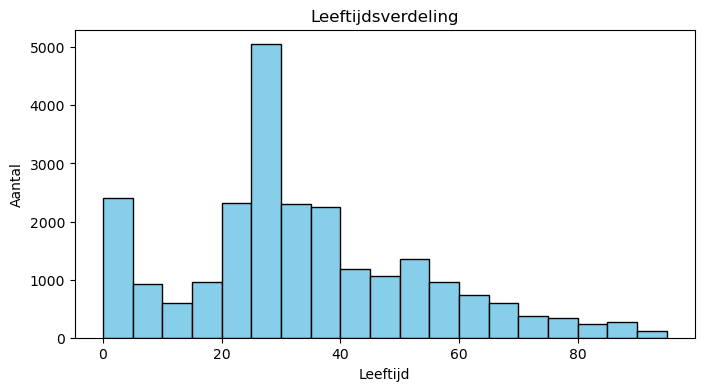

In [ ]:
#Verdeling van de leeftijden plotten

plt.figure(figsize=(8,4))
plt.hist(ages, bins=range(0, 100, 5), color='skyblue', edgecolor='black')
plt.title('Leeftijdsverdeling')
plt.xlabel('Leeftijd')
plt.ylabel('Aantal')
plt.show()

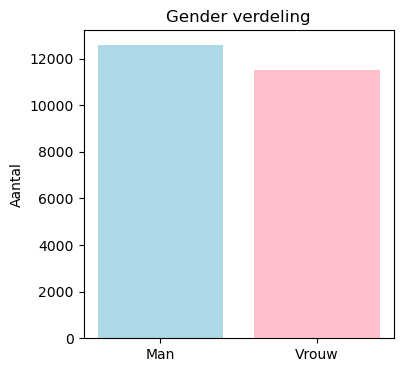

In [ ]:
#Gender verdeling plotten

plt.figure(figsize=(4,4))
plt.bar(['Man', 'Vrouw'], [genders.count(0), genders.count(1)], color=['lightblue', 'pink'])
plt.title('Gender verdeling')
plt.ylabel('Aantal')
plt.show()

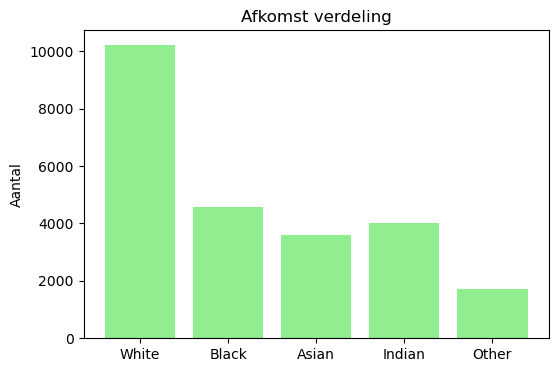

In [ ]:
# Afkomst verdeling plotten

race_labels = ['White', 'Black', 'Asian', 'Indian', 'Other']
race_counts = [races.count(i) for i in range(len(race_labels))]
plt.figure(figsize=(6,4))
plt.bar(race_labels, race_counts, color='lightgreen')
plt.title('Afkomst verdeling')
plt.ylabel('Aantal')
plt.show()

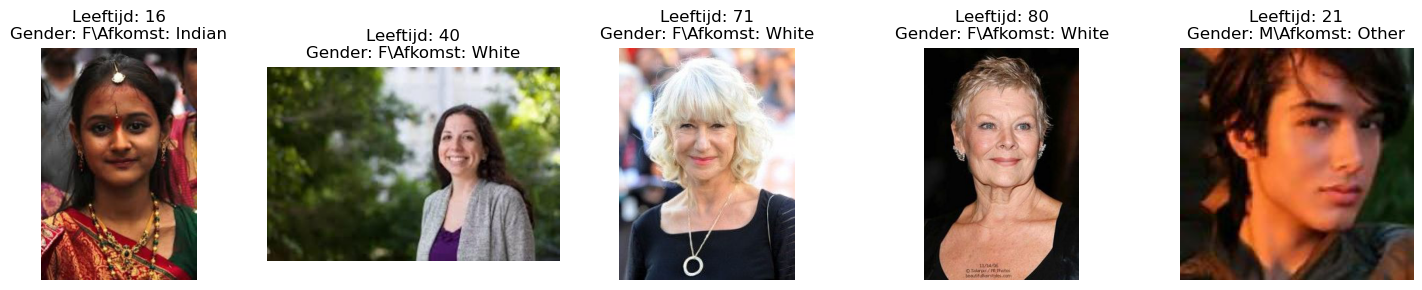

In [ ]:
#Laat een paar voorbeelden zien met labels

import matplotlib.image as mpimg
fig, axes = plt.subplots(1, 5, figsize=(15,3))
for i, ax in enumerate(axes):
    img = mpimg.imread(image_paths[i])
    ax.imshow(img)
    ax.axis('off')
    ax.set_title(f'Leeftijd: {ages[i]}\nGender: {"M" if genders[i]==0 else "F"}\Afkomst: {race_labels[races[i]]}')
plt.tight_layout()
plt.show()

## Trainen!

Omdat we veel data hebben kunnen we ervoor kiezen om op een kleinere set te trainen. Mijn computer is snel genoeg dus ik besloot wel 24104 afbeeldingen te gebruiken.

In [ ]:
#Kleinere set maken voor training
subset_size = 23701  #totaal aantal afbeeldingen is 23701, dus je kan dit aantal aanpassen naar een kleiner aantal als je computer dit niet trekt.
np.random.seed(42) #Dit kan je gelijk houden
indices = np.random.choice(len(image_paths), size=subset_size, replace=False)

image_paths = [image_paths[i] for i in indices]
ages = [ages[i] for i in indices]
genders = [genders[i] for i in indices]
races = [races[i] for i in indices]

print(f'Using a subset of {subset_size} images.')

Using a subset of 23701 images.


## Load and preprocess


In [ ]:
#Parameters
img_size = 112  #Hier mag je mee spelen, maar hoe groter hoe zwaarder voor je computer


#Laad de afbeeldingen 
X = []
for path in image_paths:
    img = load_img(path, target_size=(img_size, img_size))
    img = img_to_array(img) / 255.0
    X.append(img)
X = np.array(X)
y = np.array(ages)  #Gebruik leeftijd als target variabele


#Split de data in een train en validatieset
X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.2, random_state=42) #Waardes niet aanpassen

## Modellen trainen
Hier mogen jullie dus alles aanpassen, ik geef aan bij welke delen je niet mag aanpassen

In [ ]:
#CNN layers (DEZE KAN JE AANPASSEN)
model = models.Sequential([
    layers.Conv2D(32, (3,3), activation='relu', input_shape=(img_size, img_size, 3)),
    layers.MaxPooling2D((2,2)),
    layers.Conv2D(64, (3,3), activation='relu'),
    layers.MaxPooling2D((2,2)),
    layers.Flatten(),
    layers.Dense(64, activation='relu'),
    layers.Dense(1, activation='linear')  #dit blijft 1 want we voorspellen 1 waarde (leeftijd)
])

model.compile(optimizer='adam', loss='mean_squared_error', metrics=['mae'])

# Train the model
history = model.fit(X_train, y_train, epochs=7, batch_size=32, validation_data=(X_val, y_val))

Epoch 1/7
  1/593 [..............................] - ETA: 2:30 - loss: 1574.7333 - mae: 35.2314

2025-09-13 17:24:22.621515: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


593/593 [==============================] - ETA: 0s - loss: 387.1873 - mae: 15.1438

2025-09-13 17:24:35.251956: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


593/593 [==============================] - 15s 25ms/step - loss: 387.1873 - mae: 15.1438 - val_loss: 320.6954 - val_mae: 13.8855
Epoch 2/7
593/593 [==============================] - 14s 23ms/step - loss: 322.7658 - mae: 13.7479 - val_loss: 311.0677 - val_mae: 13.5915
Epoch 3/7
593/593 [==============================] - 14s 23ms/step - loss: 302.5683 - mae: 13.2423 - val_loss: 302.7639 - val_mae: 12.8113
Epoch 4/7
593/593 [==============================] - 13s 23ms/step - loss: 275.5553 - mae: 12.5729 - val_loss: 278.9001 - val_mae: 12.6016
Epoch 5/7
593/593 [==============================] - 14s 23ms/step - loss: 244.0786 - mae: 11.9085 - val_loss: 281.2790 - val_mae: 12.4966
Epoch 6/7
593/593 [==============================] - 14s 23ms/step - loss: 217.2729 - mae: 11.2378 - val_loss: 273.0278 - val_mae: 12.3083
Epoch 7/7
593/593 [==============================] - 14s 23ms/step - loss: 180.0249 - mae: 10.2506 - val_loss: 301.8929 - val_mae: 12.6778


## Validation and visualization

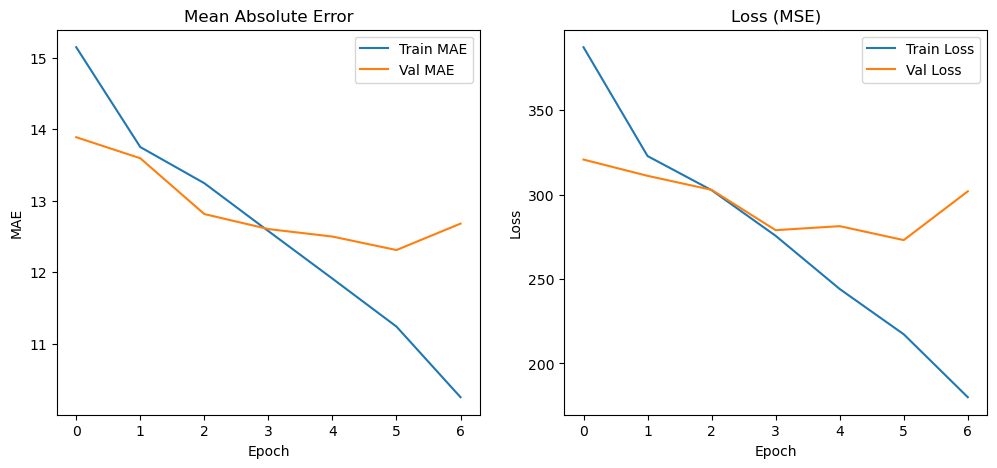

  9/149 [>.............................] - ETA: 2s

2025-09-13 17:26:29.684201: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


149/149 [==============================] - 3s 17ms/step


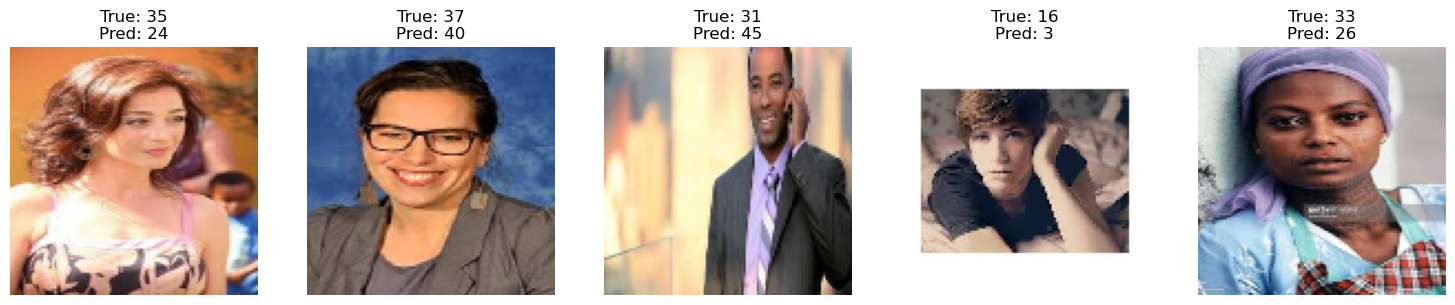

In [ ]:
# Plot training & validation MAE/loss
plt.figure(figsize=(12,5))
plt.subplot(1,2,1)
plt.plot(history.history['mae'], label='Train MAE')
plt.plot(history.history['val_mae'], label='Val MAE')
plt.title('Mean Absolute Error')
plt.xlabel('Epoch')
plt.ylabel('MAE')
plt.legend()

plt.subplot(1,2,2)
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Val Loss')
plt.title('Loss (MSE)')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.show()

# Predict and show a few validation images with predicted and true ages
preds = model.predict(X_val).flatten()

fig, axes = plt.subplots(1, 5, figsize=(15,3))
for i, ax in enumerate(axes):
    ax.imshow(X_val[i])
    ax.axis('off')
    ax.set_title(f'True: {int(y_val[i])}\nPred: {int(preds[i])}')
plt.tight_layout()
plt.show()